# Overview
Now that we've taken a look at raw data, it's time to start doing things with this data. Today we'll focus on finding events of interest in the brain activity. Specifically, we're going to focus on one of the most important tasks in any neuroscience analysis: **cleaning messy data**. There are many, many sources of noise in neuroscience, and the first step in any analysis should be to check it out and determine what's going on. 

## Goals for today
* Examining where channels lie on a person's scalp in EEG
* Looking at one of the most common sources of noise in EEG: eyeblinks.
* Extracting windows of time before/after each eyeblink
* Investigating scalp topographies to see how they relate to muscle activity.
* Calculating the "average" eyeblink, and removing it from our data.

---

# Slicing up data
Thus far, we've only browsed through raw data. However, recording from the brain is only half of the battle. We also need to understand what happened *in the outside world* in order to figure out why the brain is doing what it did.

Today, we'll attempt to understand a little more about how we can relate the outside world to the brain activity that we record.

First, we'll load some data...

In [1]:
import mne
import sys
import datascience as ds
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
# This time, we'll load both the raw data AND some events
data_path = nds.io.data_list['eeg'] + 'mne_sample/mne_sample-raw.fif'

## A quick aside on referencing
EEG and ECoG both record electrical signals, that means they record the voltage of each electrode over time. Voltage always has a *reference* signal, and in the case of EEG this can be many things. For example, we can take many forms. We'll cover two common ones here.

First, we'll load a few channels of data:

<IPython.core.display.Javascript object>


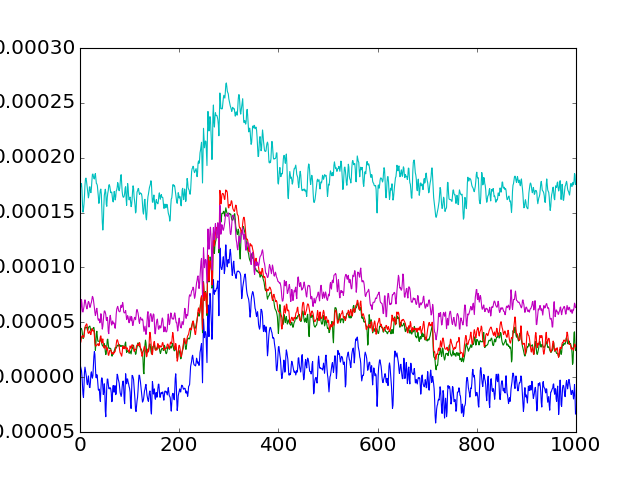

In [33]:
raw = mne.io.Raw(data_path, preload=True)
# Let's take a look at the raw data
data = raw._data[:5, :1000]
fig, ax = plt.subplots()
_ = ax.plot(data.T)

Now, we'll "reference" everything to the first channel. By "reference", we simply mean that we'll store each channels value as the difference between that channel and our reference channel. e.g.:

<IPython.core.display.Javascript object>


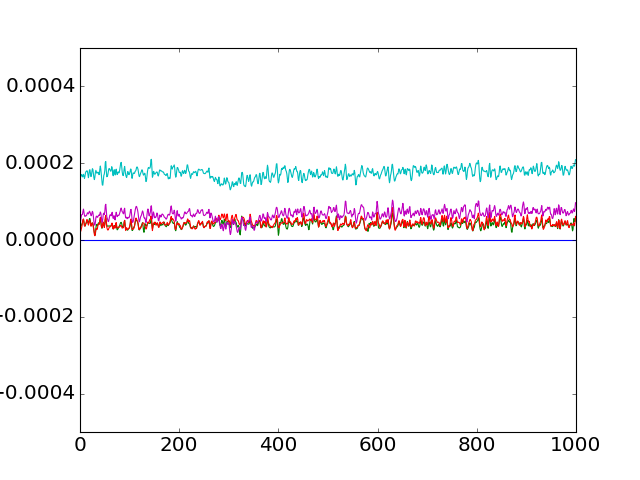

(-0.0005, 0.0005)

In [36]:
# Re-reference the data
ref_chan = 0
data = data - data[ref_chan]
fig, ax = plt.subplots()
_ = ax.plot(data.T)
ax.set_ylim([-.0005, .0005])

As you can see above, now we show each channels activity relative to the reference channel. AKA, the channels have all been referenced to a single channel.

> * What kinds of benefits do you think this could give to your data analysis?
> * What kinds of problems do you think this could introduce?

In [ ]:
### TEACHER INFO
# Benefits: you can remove noise in the signal
#   this is especially true if the noise is shared among lots of signals
#   also useful to do on a local basis (e.g. lots of references dep on location)
#   however, not often used because of the following main drawback:
# Drawbacks: Basically, you give one channel a lot of power if you reference it
#   If that channel is noisy, e.g., you'll propagate that noise everywhere.

In practice, we often don't reference our data to an electrode that's on the scalp. This is because there's brain activity in all of the scalp electrodes, and we don't want to mix the activity in our reference activity with whatever is going on in all the other areas of the scalp.

To get around this problem, we often use a *common average reference* (CAR) for our electrodes. This basically means calculating the average activity across *all* electrodes, and then using that as a reference signal. For example, with the above data:

<IPython.core.display.Javascript object>


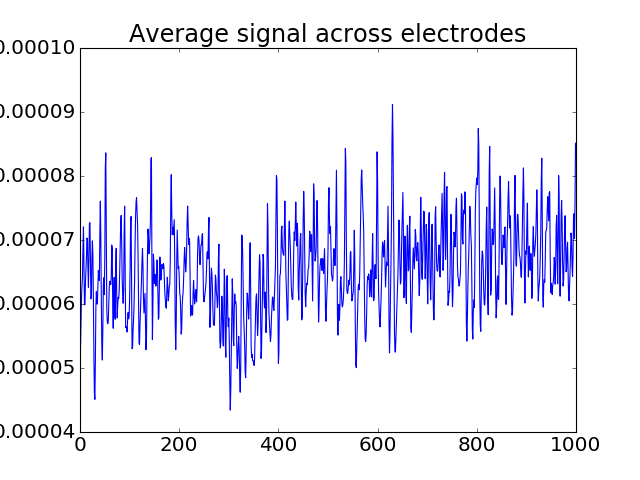

In [38]:
avg_signal = data.mean(axis=0)
fig, ax = plt.subplots()
ax.plot(avg_signal)
ax.set_title('Average signal across electrodes')

<IPython.core.display.Javascript object>


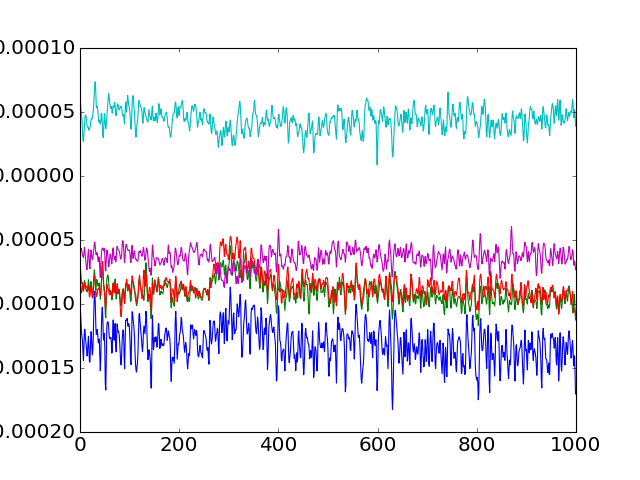

In [40]:
data = data - avg_signal
fig, ax = plt.subplots()
_ = ax.plot(data.T)

By using the common average reference, we define each channel's activity *relative to the average activity across all electrodes*. This generally ensures that any one electrode doesn't dominate the reference, and allows you to look for differences between electrodes more easily.

In MNE, we can perform a common average reference automatically when loading in the data. The `add_eeg_ref` parameter calculates the mean across all channels at each time point, and subtracts the resulting value from each channel. We'll do this below.

In [41]:
raw = mne.io.Raw(data_path, preload=True, add_eeg_ref=True)

# Finding artifacts
Now on to the analysis. In today's lecture, we'll focus on *artifacts*, which we broadly define as components of our signal that we treat as noise. We'll try to find artifact events in our data and examine their properties.

One of the simplest examples of an "event" is an eyeblink. This is actually a form of **noise** in the neural signal, because it doesn't reflect underlying brain activity. This is particularly a problem in EEG, because the electrical activity from your muscles will propagate across your skin and reach the sensors on your scalp.

First, let's scan through the data and see if we can detect the eyeblinks...

<IPython.core.display.Javascript object>


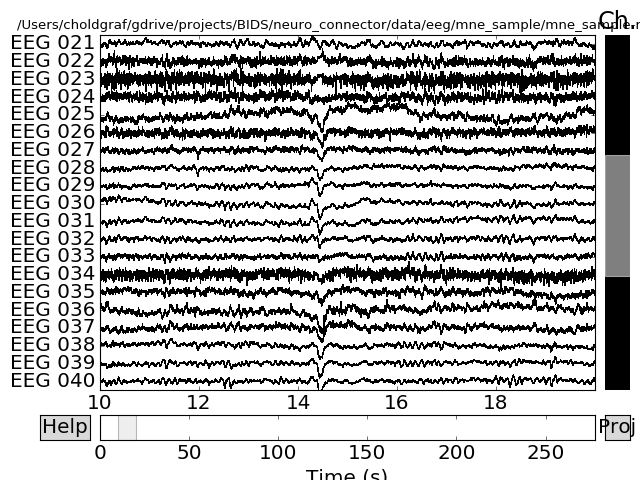

In [9]:
_ = raw.plot()

It looks like this person is blinking their eyes periodically. What does the "average" eyeblink seem to look like? Moreover, it seems like the blinks are stronger in some channels than others, why might this be?

To investigate, let's plot the location of each electrode again on the scalp.

<IPython.core.display.Javascript object>


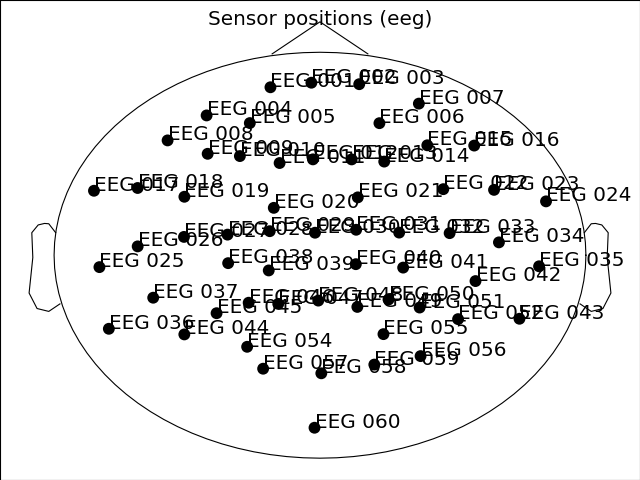

In [10]:
_ = raw.plot_sensors(show_names=True)

As we discussed in the previous lecture, we're picking up muscle activity from the eyes, and this activity is most clearly seen in the electrodes near the eyes.

### Detecting eyeblinks automatically
MNE has its own eyeblink detection algorithm built in. This is possible because eyeblinks always look very similar across people. They also have a very typical shift in shape as you move from electrode to electrode.

It is common to refer to an eyeblink signal as an **Electrooculogram (EOG)**. This refers to the electrical activity that is generated by the muscles in your eye.

Let's use the MNE eyeblinks aglorithm to do the following:

* For a single channel, find moments in time where an eyeblink seems to happen. In this case, MNE will 
* Mark the timepoint for each event.
* Define a window around each timepoint
* Combine these windows, so our data so is now shape (n_eyeblinks, n_channels, length_window)

This will return an MNE `Epochs` object, which is a way of representing data that is split up into epochs (often also called "trials").

What seems to be a good channel for doing eyeblink detection? Why would we want one channel over another?

In [48]:
# Run the MNE eyeblink detection object
epochs = mne.preprocessing.create_eog_epochs(raw, 'EEG 003')
epochs

<Epochs  |  n_events : 58 (all good), tmin : -0.499488032896 (s), tmax : 0.499488032896 (s), baseline : None, ~18.8 MB, data loaded>

MNE Epochs objects are similar to Raw objects, with some extra functionality added in because of their "epochs-based" structure.

Along with the `Epochs` object is an array that contains information about the event times, we'll look at this below...

In [50]:
# We can look at the data associated with events here:
epochs.events[:5]

array([[27184,     0,   998],
       [28001,     0,   998],
       [34485,     0,   998],
       [44122,     0,   998],
       [45390,     0,   998]])

In MNE, Events arrays are structured in the shape (n_events, 3). Here's what each column means:

1. The first column is the index of the event
2. The second column is the last value of the data before that event (you can generally ignore this, or keep it at 0)
3. The third column is the ID of the event. This is in case you have multiple event types in your data

Moreover, MNE also stores information about what event types mean. There is a dictionary that maps a string name onto each event ID.

In [36]:
# You can see the event ID mapping here.
# In this case, it's nothing interesting, but it'll be useful later.
print(epochs.event_id)

{'998': 998}


In [51]:
# That's a bit unhelpful, so we'll rename it to be more meaningful
epochs.event_id = dict(eyeblink=998)
print(epochs.event_id)

{'eyeblink': 998}


Now let's take a look at the data contained within this `Epochs` object.

In [52]:
# The raw data for the epochs is also stored as a `_data` attribute:
epochs._data[0]

array([[ -1.30715944e-05,  -1.77798465e-05,  -2.24880985e-05, ...,
         -1.12750246e-05,  -7.00042736e-06,   6.81457530e-07],
       [  2.72583002e-05,   2.53196711e-05,   2.52609248e-05, ...,
          3.65989678e-05,   3.62464897e-05,   3.60702507e-05],
       [  3.52346203e-05,   3.37262890e-05,   3.07096263e-05, ...,
          3.83116163e-05,   3.79496167e-05,   3.87339490e-05],
       ..., 
       [  7.43023673e-05,   7.05358879e-05,   6.86526481e-05, ...,
          7.97808829e-05,   7.87536612e-05,   7.84683218e-05],
       [  4.90113828e-05,   4.51565549e-05,   4.39939878e-05, ...,
          4.98068234e-05,   4.85218808e-05,   4.85830685e-05],
       [  6.56052259e-05,   6.29155286e-05,   6.12783215e-05, ...,
          6.84703383e-05,   6.84118666e-05,   6.80610365e-05]])

In [54]:
# It is shape (n_epochs, n_channels, n_times_per_epoch)
# In this case, n_epochs == n_eyeblinks
epochs._data.shape

(58, 59, 601)

In [55]:
# We can also access the times around each epoch
epochs.times[:20]

array([-0.49948803, -0.49782307, -0.49615811, -0.49449315, -0.49282819,
       -0.49116323, -0.48949827, -0.48783331, -0.48616835, -0.48450339,
       -0.48283843, -0.48117347, -0.47950851, -0.47784355, -0.47617859,
       -0.47451363, -0.47284867, -0.47118371, -0.46951875, -0.46785379])

In [56]:
# In this case, we took a 1 second window around each eyeblink.
# If we look at our sampling frequency, we can relate this to n_timepoints
# 1 second of time * n samples per second = total number of timepoints
n_seconds = 1.
n_timepoints = n_seconds * epochs.info['sfreq']
print(n_timepoints, epochs._data.shape[-1])

600.614990234375 601


# Plotting events
In MNE, we can plot the data corresponding to a time window around events. This is similar to the `Raw` plotting, but it throws out all the timepoints not associated with an event. Let's take a look:

<IPython.core.display.Javascript object>


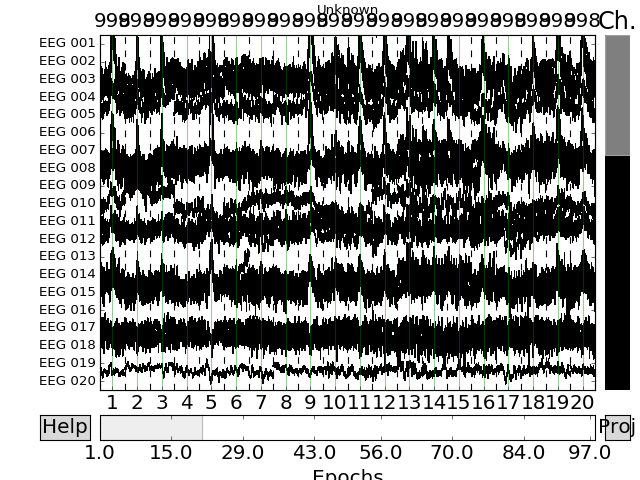

In [12]:
_ = epochs.plot()

That's a little bit hard to see detail, so we'll plot fewer trials. Let's go through this plot in a little more detail:

* We are seeing a collection of events, not a continuous timeseries like when we plotted `Raw` objects.
* The vertical dashed black lines mark borders between events
* Within each event we see the activity of each electrode from the `tmin` to `tmax`, relative to the event onset (`t==0`).
* The solid green lines mark the event onset for each event (`t==0`).
* The numbers at the top show the event ID for each event (in this case, they're all eyeblinks)
Here we see a window of activity around each event, for each channel

<IPython.core.display.Javascript object>


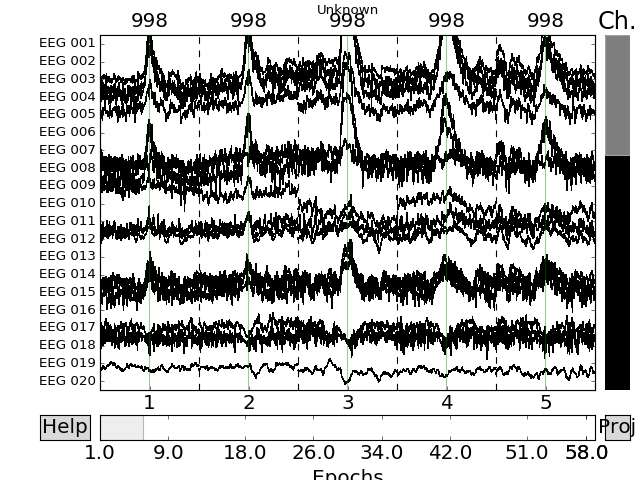

In [57]:
_ = epochs.plot(n_epochs=5)

> * What can we say about these events? Is there a regular shape that pops out?
> * Why does the event activity change when you compare across electrodes?
> * Does this seem to perfectly pick out events?

In [58]:
### TEACHER INFO
# Just describe the general shape of each eyeblink and note that it's consistent.
# The activity changes because we get further from the muscle activity.
# It doesn't always pick out an obvious eyeblink, so not perfect.

# Averaging across events
While it's important to look at the raw events, it is more useful to get a summary of what events look like in general.

The simplest way to summarize activity in neuroscience is to record a number of events, then average the activity across them. We do this because of the following logic:

1. Our data is comprised of two things: signal + noise
  1. The signal is whatever the brain does in response to the world.
  1. The noise is random fluctuations around our "true" signal
1. If we record lots of instances of the same event, then we have many signals which should look the same. However, the **noise should be random, and not correlated across events**.
1. If we average across events, then we **keep the signal, and average out the noise**.

We can see this in action below. First, we'll use the raw data:

(58, 59, 601)
(59, 601)


<IPython.core.display.Javascript object>


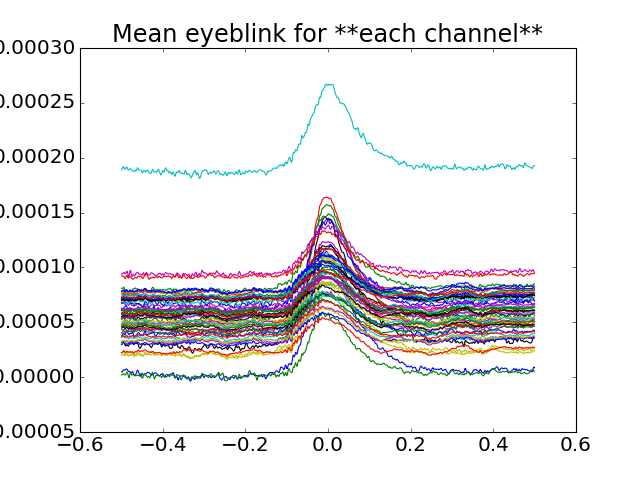

(601,)


<IPython.core.display.Javascript object>


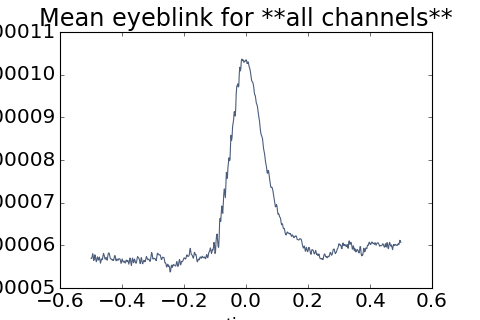

In [60]:
# We'll take the mean across all epochs
print(epochs._data.shape)
mean_epoch = epochs._data.mean(axis=0)
print(mean_epoch.shape)

# We'll plot the average eyeblink for *each channel*
fig, ax = plt.subplots()
ax.plot(epochs.times, mean_epoch.T)
ax.set_title('Mean eyeblink for **each channel**')

# Now the average across all channels
mean_epoch = mean_epoch.mean(axis=0)
print(mean_epoch.shape)

# Now we'll plot the result
mean_epoch = ds.Table().with_columns([('data', mean_epoch),
                                      ('time', epochs.times)])
mean_epoch.plot('time', 'data')
plt.title('Mean eyeblink for **all channels**')

That's what an eyeblink looks like. We can also quickly glance at what the eyeblink looks like by using MNE's averaging and plotting functionality.

<IPython.core.display.Javascript object>


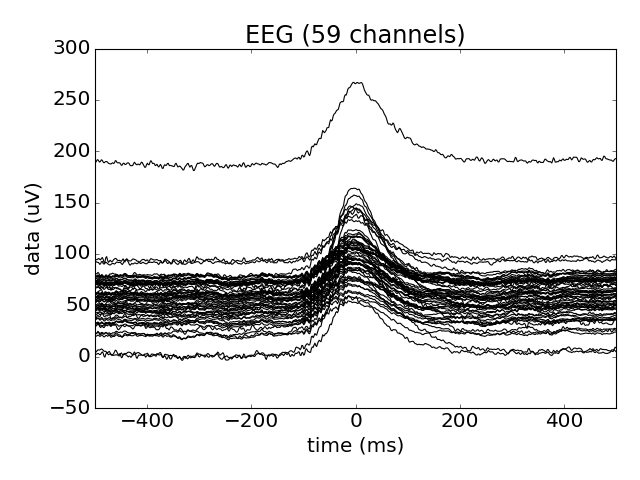

In [61]:
# Average across trials, and then plot the result for each channel.
average = epochs.average()
_ = average.plot()

## Scalp Topographic Maps
As we've noted several times, the pattern of activity changes across both time *and* channels. For example, eyeblinks become less strong as we move away from the eyes. We can visualize a pattern of activity as you move across electrodes with a *scalp topography*. This is a way showing the activity at a moment in time, where each electrode's color reflects its voltage.

In MNE there are quick functions for plotting scalp topographies with EEG:

<IPython.core.display.Javascript object>


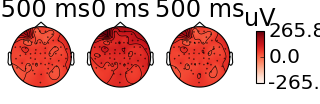

Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.


/Users/choldgraf/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.
  if __name__ == '__main__':


In [63]:
_ = average.plot_topomap(times=[-.5, 0, .5])

We can even combine the above plot with our time-varying plots, to see how the scalp topography changes over the course of the trial. Below we'll plot the average activity for each electrode, and the scalp topography at a few moments of interest:

<IPython.core.display.Javascript object>


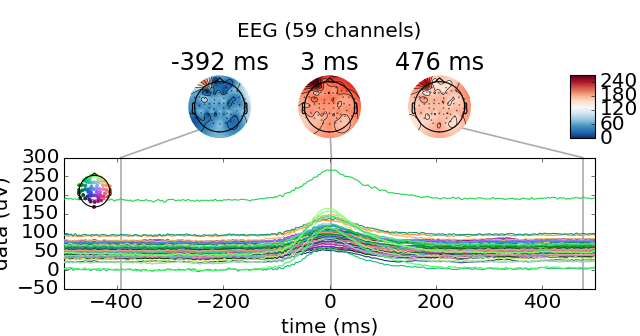

Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.


/Users/choldgraf/anaconda/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Disabling interactive colorbar for multiple axes. Turn interactivity on explicitly by passing cmap as a tuple.
  if __name__ == '__main__':


In [64]:
_ = average.plot_joint(topomap_args=dict(vmin=0))

> * You might notice that the color seems a little bit off here, why do you think this is?

In [65]:
### TEACHER INFO
# If you look at the average plots, the baseline for each channel is off.
# We'll go through baselining in the lab to see how this changes things.

Finally, we can plot each waveform as an individual plot at the electrode's location. This is called a topo-plot:

<IPython.core.display.Javascript object>


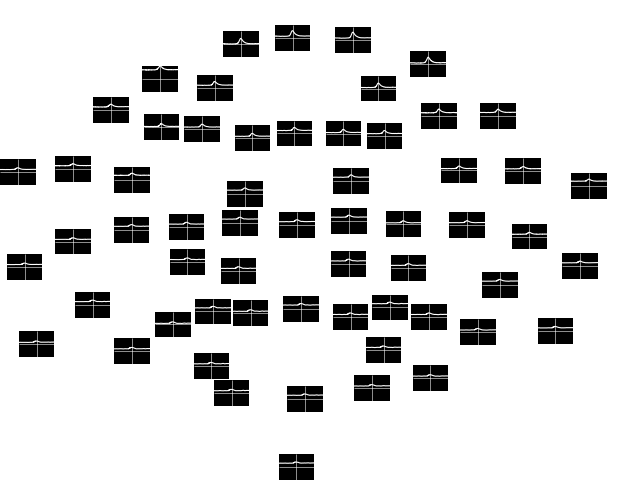

In [66]:
# We can also amek a "topographic" plot, or "topoplot"
# In this case, each plot is the location of a sensor.
_ = average.plot_topo()

> * Where do you think the front of the brain is on the plot above? Why?
> * What are some reasons you can think of for using a topographic map? What about a topographic plot?

In [67]:
### TEACHER INFO
# Front is towards the top because the traces are larger (near eyes)
# Topographic maps highlight the differences distributed across the brain
# Topographic plots (like above) show more timing information
#   However, they're harder to compare between electrodes
#   Maybe make a point about how visualizations should be chosen to highlight
#   The comparison you want the student to make.

# Lab time!